<div class="alert alert-block alert-info"><h1 style="text-align:center;color:black"> Fashion style Classification Problem 📷 🚀 </h1> </div>
The Dogs & Cats is a foundational problem for a basic CNN(convolutional neural network) model which involves classifying images as a fashion styles.The dataset can be used for learning how to develop,evaluate and use convolutional deep learning neural networks for classification of images. This includes how to develop a robust test harness for estimating the performance of the model, exploring improvements for the model by changing the paramters of the model, saving and loading the model to make predicitions on new data.

![fashion](..//fashion_styles_recognition/Datasets/dataset-cover.png)

<div class="alert alert-block alert-warning"><h2 style="text-align:Center;color:black">Table of Content </h2> </div>

1. [Introduction 💥](#1)
1. [Data Description](#2)
1. [Loading Libraries📖](#3)
1. [Data Extraction📁](#4)
1. [Data Exploration📊](#5)
1. [Train Test Split](#6)
    1. [Using Dataframe](#7)
    1. [Using Directory](#8)
1. [Data Preparation 🛠️](#9)
    1. [Image Data Generator](#10)
        1. [Using DataFrame](#11)
        1. [Using Directory](#12)
1. [Deep learning Model ⚙️](#13)
    1. [Model Layers](#14)
    1. [Callbacks](#15)
    1. [Compile Model](#23)
    1. [Fit Model](#16)
    1. [Plot Result](#17)
    1. [Evaluvation](#18)
1. [Prediction](#19)
    1. [Visualize Classified Images](#20)
1. [Submission](#21)
1. [Conclusion](#22)

<a id='1'></a>
<div class="alert alert-block alert-danger"><h2 style="text-align:center;color:black"> Introduction 💥</h2> </div> 

In this notebook, we will discover how to develop a CNN to classify images of fashion_styles.

We will follow this steps:

* Load and prepare the images for training purpose.
* Split data for training and validation purpose.
* Apply Data Augmentation to the data.
* Develop a CNN model using keras and how to choose various parameters for improving performance of the model.
* Evaluate performance of our model.
* Save and load a model for further predictions.
* Draw the confusion matrix for trained model.

<a id='2'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Description </h2> </div>

The training archive contains 44,110 images of fashion styles.

Train your algorithm on these files and predict the labels.


<a id='3'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Loading Libraries </h2> </div>

In [70]:
# Basic
import warnings

from fastjsonschema import validate
from jupyterlab.browser_check import test_flags

warnings.filterwarnings('ignore')

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [71]:
#Define the source dir where the images come from
source = '../fashion_styles_recognition/Datasets/fashion-dataset/images'

# We will save in this dir the files we select to train the model
working_dir = '../fashion_styles_recognition/Datasets/fashion-dataset/working'

# We will classify in this dir the images classified by sytle
train_test_dir = '../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/'

# We will classify in this dir the images classified by sytle
validate_dir = '../fashion_styles_recognition/Datasets/fashion-dataset/validate_styles/'

In [72]:
makedirs(working_dir, exist_ok=True)
makedirs(train_test_dir, exist_ok=True)
makedirs(validate_dir, exist_ok=True)

In [73]:
#We remove files of previous executions
for filename in os.listdir(working_dir):
    os.remove(os.path.join(working_dir, filename))

In [74]:
for dirname, _, filenames in os.walk(train_test_dir):
    for filename in filenames:
        os.remove(os.path.join(dirname, filename))

In [75]:
for dirname, _, filenames in os.walk(validate_dir):
    for filename in filenames:
        os.remove(os.path.join(dirname, filename))

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Extraction </h2> </div>

In [76]:
#We indicate where the data we will use is
files_dir = "../fashion_styles_recognition/Datasets/fashion-dataset/images/"

### Loading Images in a Dataframe

In [77]:
#We create a dataframe with the info of the images in the datasets
csv_dir = "../fashion_styles_recognition/Datasets/fashion-dataset/"

data = pd.read_csv(csv_dir + "styles.csv", sep=";")

In [78]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [79]:
#We review which categores we have in Mater category
data.masterCategory.unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [80]:
data = data[data['masterCategory'] == 'Apparel']

In [81]:
#We review the article type
data.articleType.unique()

array(['Shirts', 'Jeans', 'Track Pants', 'Tshirts', 'Tops', 'Bra',
       'Sweatshirts', 'Kurtas', 'Waistcoat', 'Shorts', 'Briefs', 'Sarees',
       'Innerwear Vests', 'Rain Jacket', 'Dresses', 'Night suits',
       'Skirts', 'Blazers', 'Kurta Sets', 'Shrug', 'Trousers',
       'Camisoles', 'Boxers', 'Dupatta', 'Capris', 'Bath Robe', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Sweaters', 'Tracksuits',
       'Swimwear', 'Nightdress', 'Baby Dolls', 'Leggings', 'Kurtis',
       'Jumpsuit', 'Suspenders', 'Robe', 'Salwar and Dupatta', 'Patiala',
       'Stockings', 'Tights', 'Churidar', 'Lounge Tshirts',
       'Lounge Shorts', 'Shapewear', 'Nehru Jackets', 'Salwar',
       'Jeggings', 'Rompers', 'Booties', 'Lehenga Choli', 'Clothing Set',
       'Belts', 'Rain Trousers', 'Suits'], dtype=object)

In [82]:
# We erase all the types we don't need like underwear, socks, nightwear, etc
not_wanted = ['Bra','Briefs','Boxers','Innerwear Vests','Night suits','Baby Dolls','Nightdress','Swimwear','Suspenders','Robe','Stockings','Tights','Lounge Tshirts',
       'Lounge Shorts','Shapewear','Belts']

In [83]:
data = data[~data.articleType.isin(not_wanted)]

In [84]:
#Name of the file
data['filename_source'] = data['id'].astype(str) + '.jpg'

#Name of the style
data['label'] = data['usage']

#Origin route
data['source'] = source + '/' + data['filename_source']

#Filename in the destination route. It contains the label + id
data['filename_destination'] = data['usage'] + '.' + data['filename_source']

#Destination route
# data['destination'] = working_dir + '/' + data['filename_destination']

#We remove the cells we don't need
data.drop(labels=['gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'], axis=1, inplace=True)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19283 entries, 0 to 44443
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    19283 non-null  int64 
 1   filename_source       19283 non-null  object
 2   label                 19264 non-null  object
 3   source                19283 non-null  object
 4   filename_destination  19264 non-null  object
dtypes: int64(1), object(4)
memory usage: 903.9+ KB


In [86]:
#We delete the registers whose label is null
data = data[data.label.notna()]

In [87]:
#We check if we actually have an image file for the registers
images = os.listdir(source)
data['exists'] = data.filename_source.isin(images)

data = data[data['exists'] == True]

data.drop(labels='exists', axis=1, inplace=True)

In [88]:
data.groupby('label').count()

,id,filename_source,source,filename_destination
label,,,,
Casual,13569,13569,13569,13569
Ethnic,2960,2960,2960,2960
Formal,1129,1129,1129,1129
Party,22,22,22,22
Smart Casual,21,21,21,21
Sports,1557,1557,1557,1557
Travel,1,1,1,1


In [89]:
# #Casual style has many registers. We select only 1610
casual_style = data[data['label'] == 'Casual'].sample(1610)
ethnic_style = data[data['label'] == 'Ethnic'].sample(1610)

In [90]:
#There are registers with only a few registers. We select only the styles with more than 1000
rest_styles = data[
    (data['label'] == 'Formal') |
    (data['label'] == 'Sports')
]

In [91]:
# We make a dataframe with the selected styles
data = pd.concat([casual_style, ethnic_style, rest_styles], ignore_index=True)

In [92]:
# We will need 10 files of each style to validate the model
# We generate list with 10 random id's of each style
Casual_validate = list(data[data['label'] == 'Casual']['id'].sample(5))
Ethnic_validate = list(data[data['label'] == 'Ethnic']['id'].sample(5))
Formal_validate = list(data[data['label'] == 'Formal']['id'].sample(5))
Sports_validate = list(data[data['label'] == 'Sports']['id'].sample(5))

In [93]:
# We aggregate all the ids of each style in one list
styles_validate = []

for style in [Casual_validate, Ethnic_validate, Formal_validate, Sports_validate]:
    styles_validate.extend(style)

In [94]:
# We will move the selected images for validation to the validation folder
# We will use the rest of images to train and test the model and we will move these images to the destination folder
data['destination'] = np.where(data['id'].isin(styles_validate),
                               validate_dir + data['filename_destination'],
                               working_dir + '/' + data['filename_destination'])

In [95]:
for i in data.index:
    src_path = data['source'][i]
    dst_path = data['destination'][i]
    copyfile(src_path, dst_path)

<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

<h5 style="text-align:center;color:Green">We visualize few images of Casual Style. </h5>

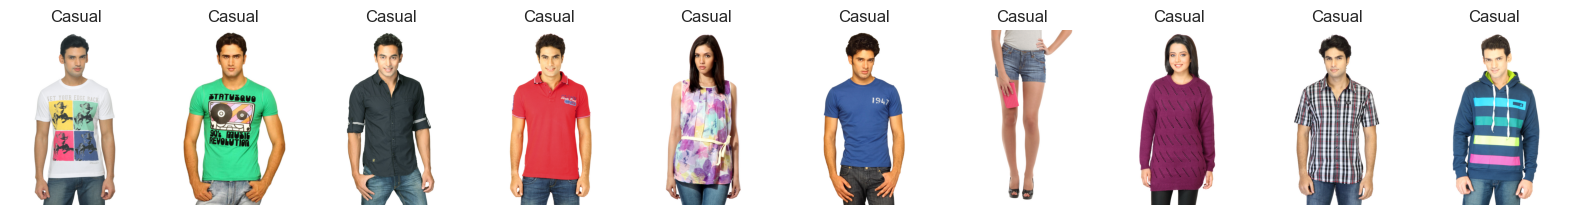

In [96]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

df_label = data[data['label'] == 'Casual'][['destination']]
df_label.reset_index(drop=True, inplace=True)

for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = df_label['destination'][i]
    image = imread(filename)
    plt.imshow(image)
    plt.title('Casual',fontsize=12)
    plt.axis('off')

plt.show()

<h5 style="text-align:center;color:Red">We visualize few images of Etnic style. </h5>

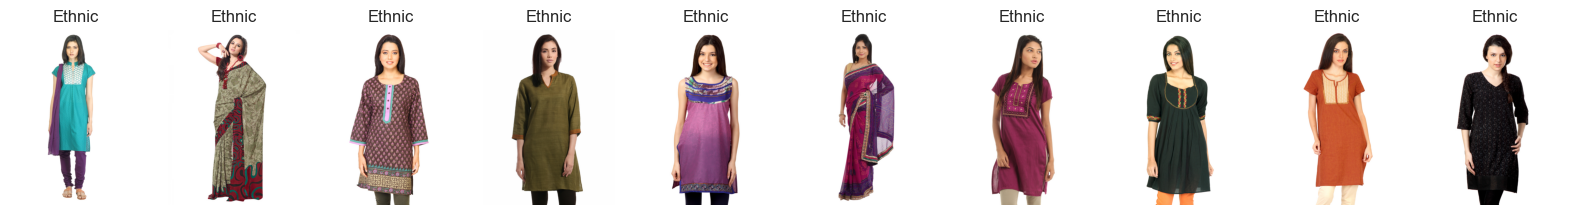

In [97]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

df_label = data[data['label'] == 'Ethnic'][['destination']]
df_label.reset_index(drop=True, inplace=True)

for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = df_label['destination'][i]
    image = imread(filename)
    plt.imshow(image)
    plt.title('Ethnic',fontsize=12)
    plt.axis('off')

plt.show()

<h5 style="text-align:center;color:Red">We visualize few images of Sports style. </h5>

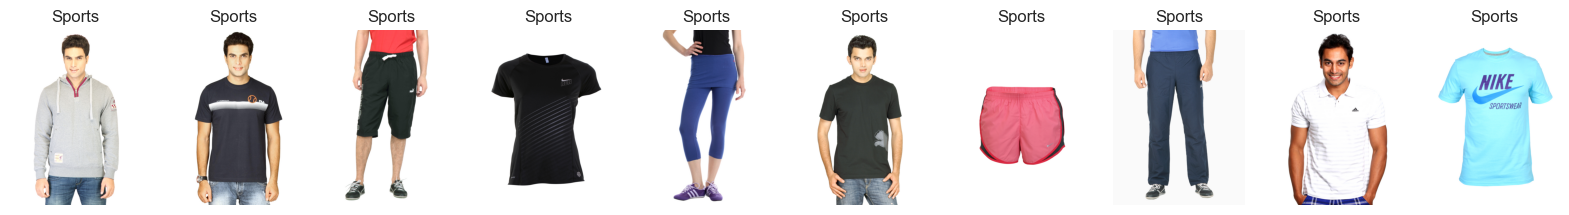

In [98]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

df_label = data[data['label'] == 'Sports'][['destination']]
df_label.reset_index(drop=True, inplace=True)

for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = df_label['destination'][i]
    image = imread(filename)
    plt.imshow(image)
    plt.title('Sports',fontsize=12)
    plt.axis('off')

plt.show()

<h5 style="text-align:center;color:Red">We visualize few images of Formal style. </h5>

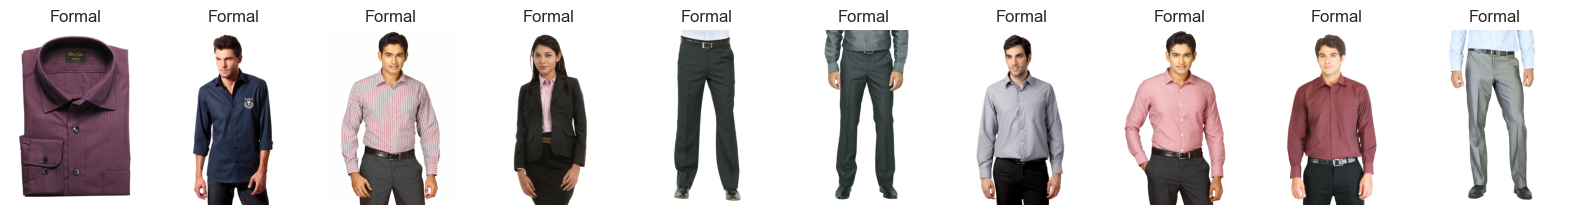

In [99]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

df_label = data[data['label'] == 'Formal'][['destination']]
df_label.reset_index(drop=True, inplace=True)

for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = df_label['destination'][i]
    image = imread(filename)
    plt.imshow(image)
    plt.title('Formal',fontsize=12)
    plt.axis('off')

plt.show()

Images are of varying size.

Every time the cell is run different set of images will be displayed, one can scan the images of both categories. Presence of humans in some images could be a challenge for the model to classify.

Some images have more than one cats or dogs respectively.

<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

<a id='7'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Using Dataframe </h4> </div>

In [100]:
# train test split using dataframe

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (4724, 6)
The shape of test data (591, 6)
The shape of validation data (591, 6)


Now we will Create a barplot to see the class distrubtion in trainting dataset.

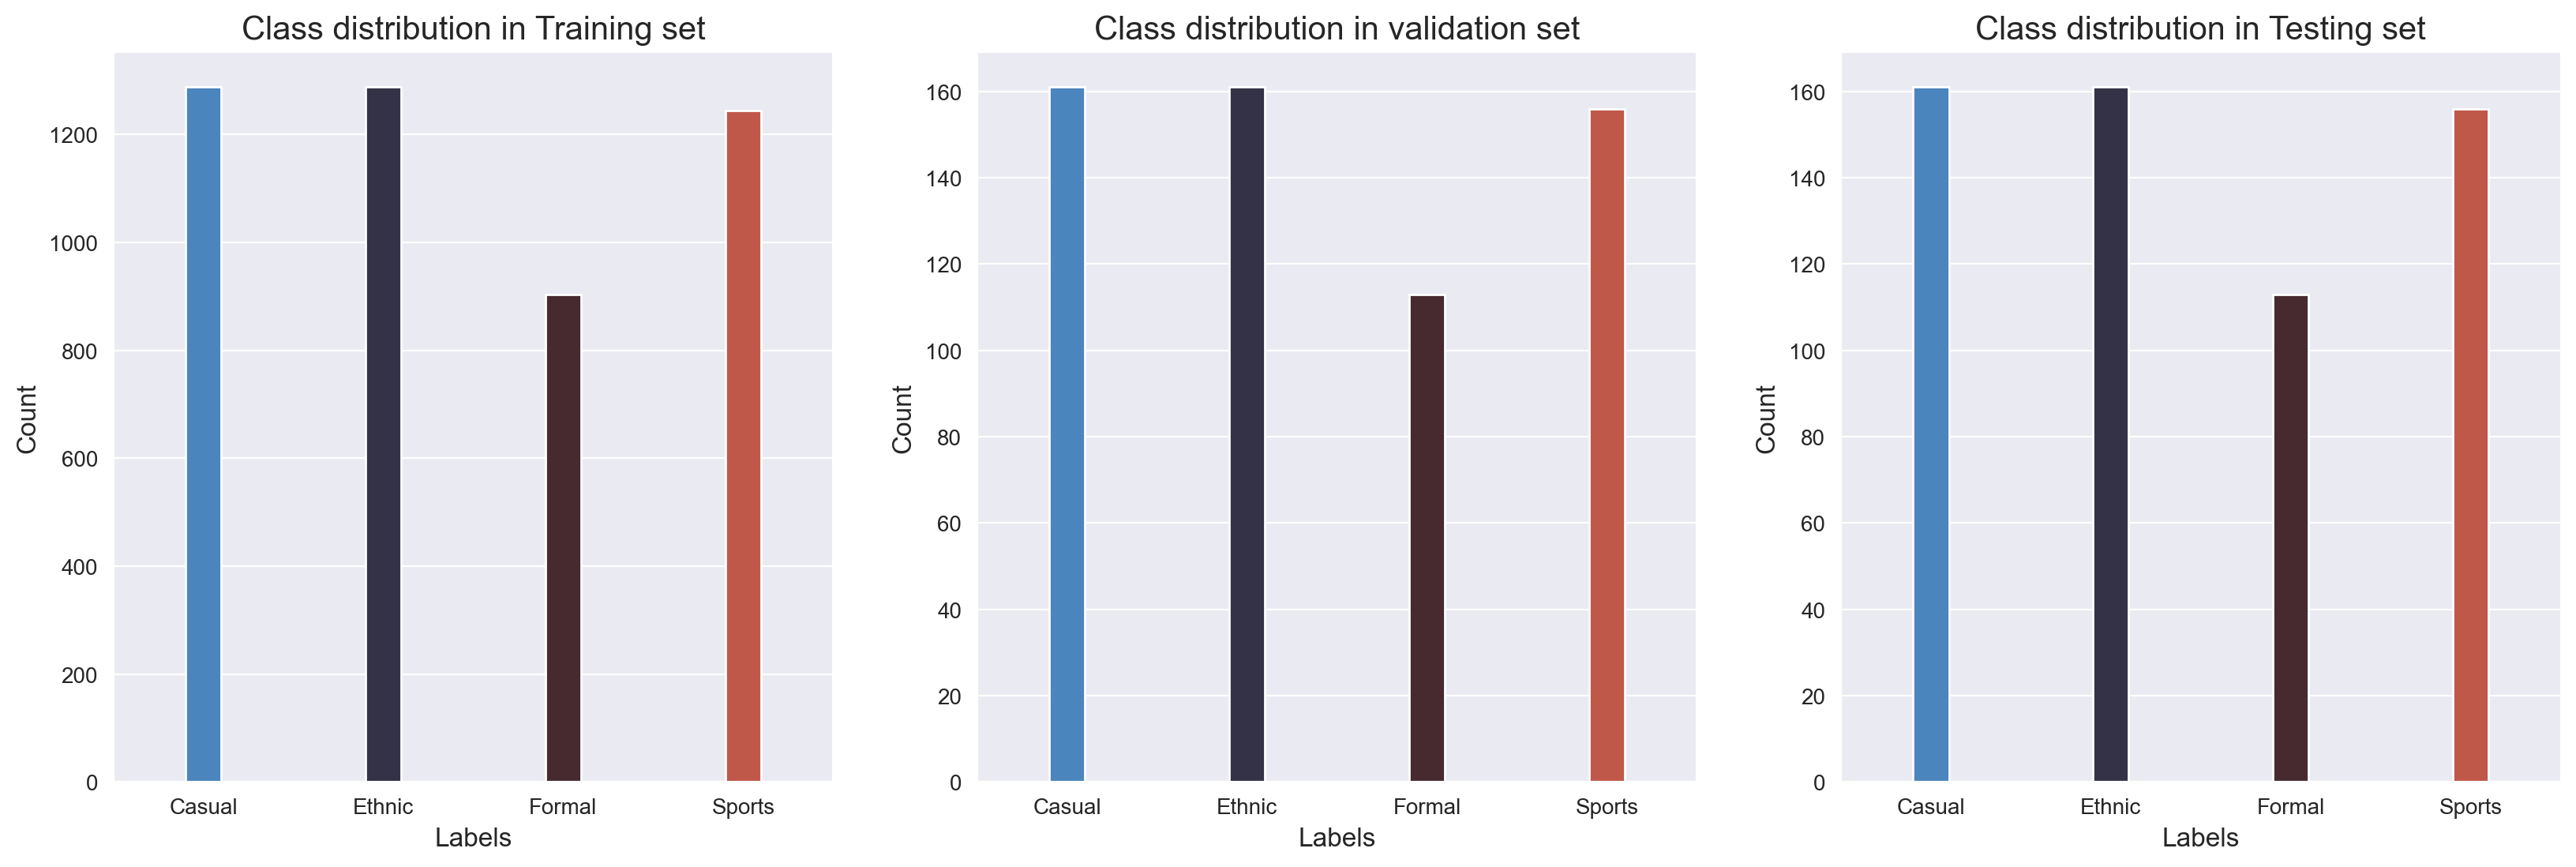

In [101]:
labels = list(data.label.unique())

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

+<a id='8'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Using Directory </h4> </div>

In [102]:
# create directories
subdirs = ['train/', 'test/']

In [103]:
for subdir in subdirs:
    # create label subdirectories
    labeldirs = []
    for label in labels:
        labeldirs.append(label + '/')
    for labldir in labeldirs:
        newdir = train_test_dir + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [104]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2

In [105]:
# copy training dataset images into subdirectories
src_directory = '../fashion_styles_recognition/Datasets/fashion-dataset/working'
for file in listdir(src_directory):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('Casual'):
            dst = train_test_dir + dst_dir + 'Casual/' + file
            copyfile(src, dst)
        elif file.startswith('Ethnic'):
            dst = train_test_dir + dst_dir + 'Ethnic/' + file
            copyfile(src, dst)
        elif file.startswith('Formal'):
            dst = train_test_dir + dst_dir + 'Formal/' + file
            copyfile(src, dst)
        elif file.startswith('Sports'):
            dst = train_test_dir + dst_dir + 'Sports/' + file
            copyfile(src, dst)

In [106]:
path1 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/train/Casual"
path2 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/train/Ethnic"
path3 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/train/Formal"
path4 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/train/Sports"
path5 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/test/Casual"
path6 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/test/Ethnic"
path7 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/test/Formal"
path8 = "../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/test/Sports"


print('Then number of Casual images in training data is' ,len(os.listdir(path1)))
print('Then number of Ethnic images in training data is' ,len(os.listdir(path2)))
print('Then number of Formal images in training data is' ,len(os.listdir(path3)))
print('Then number of Sports images in training data is' ,len(os.listdir(path4)))
print('Then number of Casual images in validation data is' ,len(os.listdir(path5)))
print('Then number of Ethnic images in validation data is' ,len(os.listdir(path6)))
print('Then number of Formal images in validation data is' ,len(os.listdir(path7)))
print('Then number of Sports images in validation data is' ,len(os.listdir(path8)))


Then number of Casual images in training data is 1307
Then number of Ethnic images in training data is 1264
Then number of Formal images in training data is 894
Then number of Sports images in training data is 1252
Then number of Casual images in validation data is 298
Then number of Ethnic images in validation data is 341
Then number of Formal images in validation data is 230
Then number of Sports images in validation data is 300


<a id='9'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

firstly, we will list out all the important parameters and respective values.

In [107]:
# parameters
image_size = 128
image_channel = 3
bat_size = 32

<a id='10'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Image Data Generator </h3> </div>

* The data for will used by flow_from_dataframe and flow_from_directory.
* The batch size is 32 and the image size is (128,128).


In [108]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

<a id='11'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Using Dataframe </h4> </div>

In [109]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = '../fashion_styles_recognition/Datasets/fashion-dataset/working',
                                                    x_col= 'filename_destination',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = '../fashion_styles_recognition/Datasets/fashion-dataset/working',
                                                 x_col= 'filename_destination',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = '../fashion_styles_recognition/Datasets/fashion-dataset/working',
                                                  x_col= 'filename_destination',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 4706 validated image filenames belonging to 4 classes.
Found 591 validated image filenames belonging to 4 classes.
Found 589 validated image filenames belonging to 4 classes.


<a id='12'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Using Directory </h4> </div>

In [110]:
train_gen = train_datagen.flow_from_directory('../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/train/',
                                              class_mode='binary',
                                              target_size = (image_size,image_size),
                                              batch_size = bat_size,
                                             )

val_gen = test_datagen.flow_from_directory('../fashion_styles_recognition/Datasets/fashion-dataset/train_test_styles/test/',
                                          class_mode='binary',
                                          batch_size = bat_size,
                                          target_size = (image_size,image_size),
                                          shuffle = False
                                         )

Found 4717 images belonging to 4 classes.
Found 1169 images belonging to 4 classes.


<a id='13'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Deep Learning Model </h2> </div>

<a id='14'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Model Layers </h3> </div>


### Architecture

The architecture of the Cat vs Dog Image Classification model consists of the following Layers and components:

#### Layers :
* The input layer consist of a Conv2D with 32 filters and activation relu.
* The model contain the 3 blocks of convolution with increasing filters and activation relu.
* Each convolution block contains Batch Noramlization, Max pooling (pool_size = 2) and Dropout (0.2).
* The fully connected layers contain Flatten layer, Dense layer with 512 units and a Dropout layer.
* The output layer is a Dense layer with 2 units and softmax activation.

#### Components:

* **Input Layer:** Receives input images for classification.
* **Convolutional Layers:** Extract features from the images through convolutional operations.
* **Pooling Layers:** Reduce the spatial dimensions of the feature maps.
* **Flatten Layer:** Convert the 2D feature maps into a 1D vector.
* **Fully Connected Layers:** Perform classification using densely connected layers.
* **Output Layer:** Provides the final prediction probabilities for each fashion style classes.

In [111]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,113,540 (19.51 MB)

 Trainable params: 5,111,556 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

<a id='15'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Callbacks </h3> </div>
we will be using two callbacks -

* **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.
* **EarlyStopping :** Stop training when a monitored metric has stopped improving.

In [112]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

<a id='23'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Compile the model </h3> </div>
Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics

* **Optimizer** :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
​
* **Loss** :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.
​
* **Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [113]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

<a id='16'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Fit the model </h3> </div>

We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 30 epochs.

In [114]:
styles_model = model.fit(train_generator,
                         validation_data = val_generator,
                         callbacks=[early_stoping,learning_rate_reduction],
                         epochs = 30,
                         # steps_per_epoch = len(train_generator),
                         # validation_steps = len(val_generaotor),
                         )

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 7:48 3s/step - accuracy: 0.3438 - loss: 0.842 ━━━━━━━━━━━━━━━━━━━━ 1:15 514ms/step - accuracy: 0.2969 - loss: 1.05 ━━━━━━━━━━━━━━━━━━━━ 1:17 535ms/step - accuracy: 0.2847 - loss: 1.10 ━━━━━━━━━━━━━━━━━━━━ 1:20 556ms/step - accuracy: 0.2897 - loss: 1.11 ━━━━━━━━━━━━━━━━━━━━ 1:22 578ms/step - accuracy: 0.3005 - loss: 1.10 ━━━━━━━━━━━━━━━━━━━━ 1:22 580ms/step - accuracy: 0.3129 - loss: 1.09 ━━━━━━━━━━━━━━━━━━━━ 1:20 574ms/step - accuracy: 0.3205 - loss: 1.09 ━━━━━━━━━━━━━━━━━━━━ 1:21 580ms/step - accuracy: 0.3239 - loss: 1.08 ━━━━━━━━━━━━━━━━━━━━ 1:20 581ms/step - accuracy: 0.3304 - loss: 1.07 ━━━━━━━━━━━━━━━━━━━━ 1:20 581ms/step - accuracy: 0.3367 - loss: 1.06 ━━━━━━━━━━━━━━━━━━━━ 1:19 582ms/step - accuracy: 0.3435 - loss: 1.05 ━━━━━━━━━━━━━━━━━━━━ 1:18 580ms/step - accuracy: 0.3518 - loss: 1.04 ━━━━━━━━━━━━━━━━━━━━ 1:18 582ms/step - accuracy: 0.3602 - loss: 1.03 ━━━━━━━━━━━━━━━━━━━━ 1:18 583ms/step - accuracy: 0.3675 - loss: 1.02 ━━━━━━━━━━━━━━━━━

<a id='17'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the results </h3> </div>

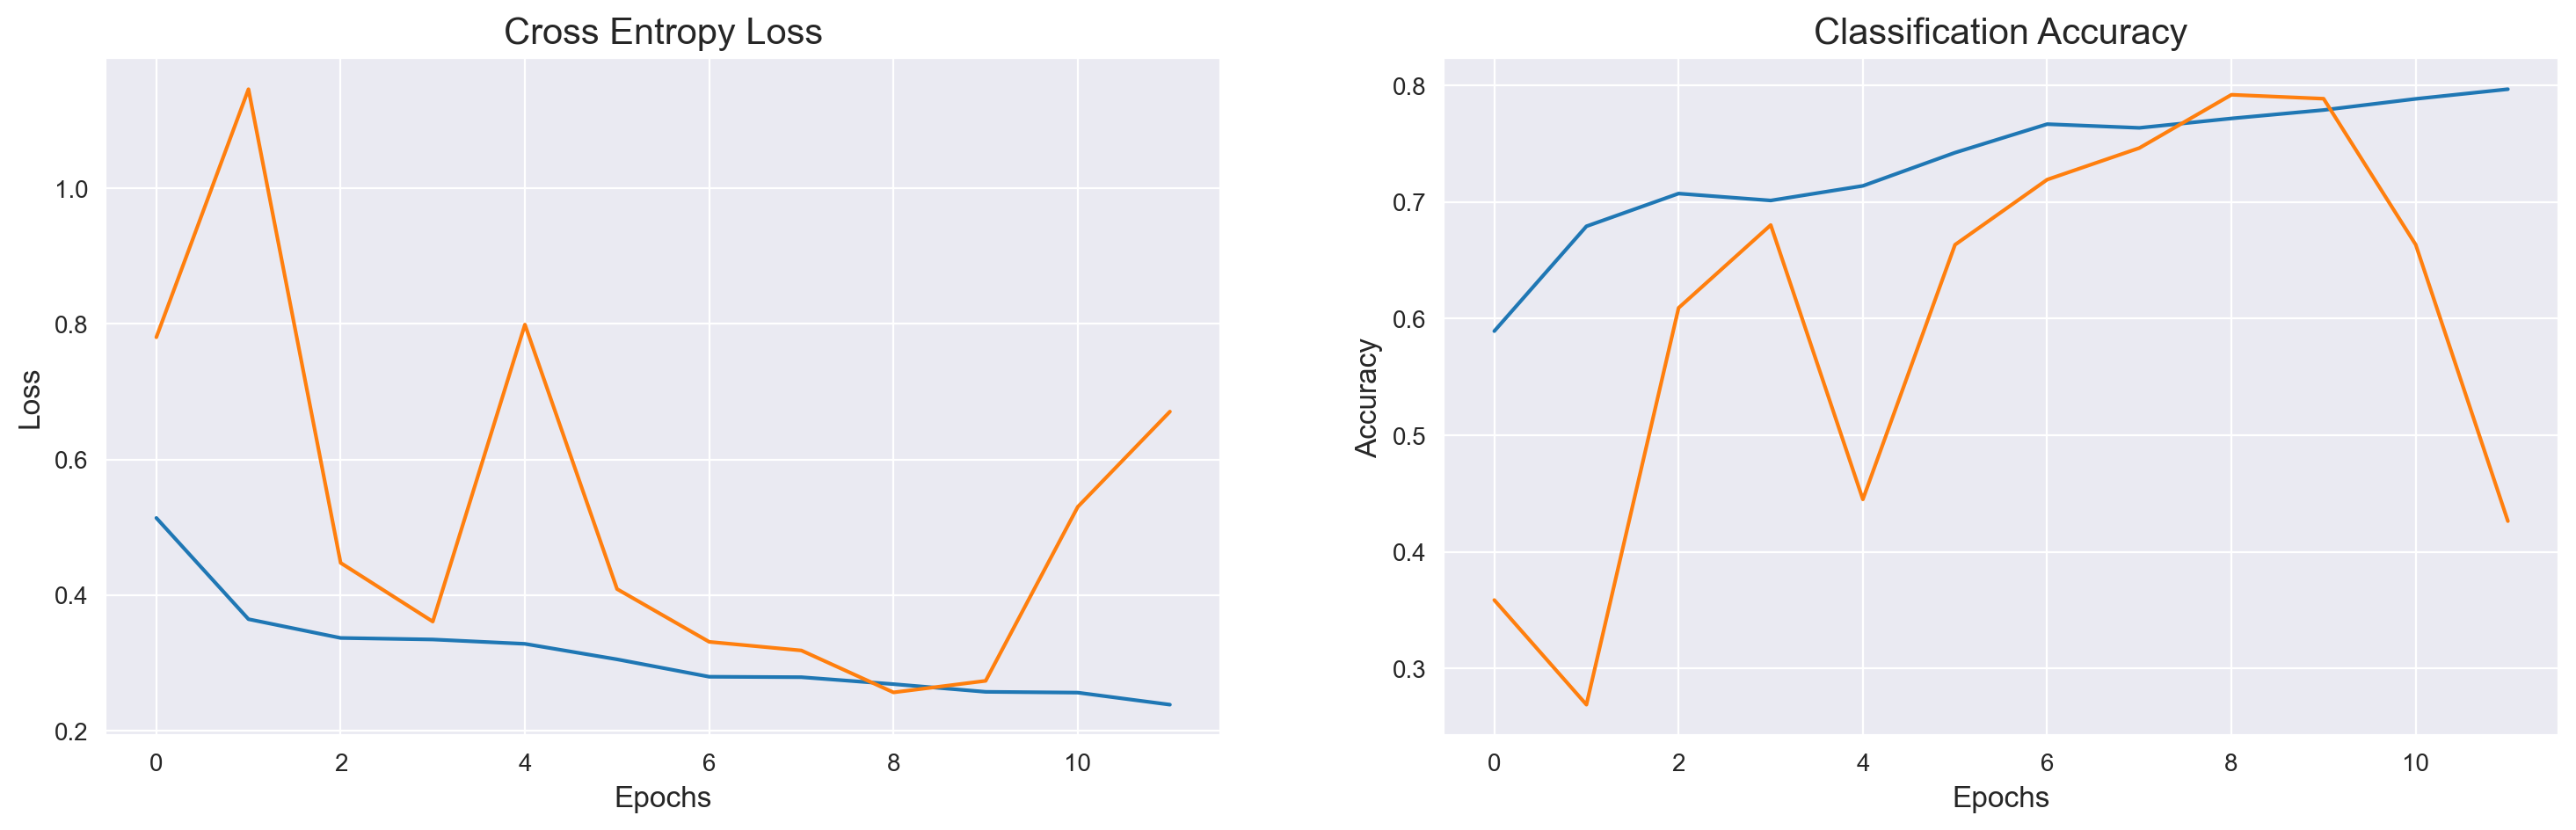

In [115]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(styles_model.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<a id='18'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Evaluvation </h3> </div>

we will evaluvate the Training and validation data accuracy and loss.

In [116]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 73.62940907478333
The Loss of the model for training data is: 0.2934342622756958
The accuracy of the model for validation data is: 79.18781638145447
The Loss of the model for validation data is: 0.2564196288585663


Finally, we will save the model for future use.

In [117]:
# Save the Model
model.save("model.h5")

<a id='19'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Prediction </h2> </div>

Now, we will predict the model on test dataset.

In [118]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 82.68251419067383
The Loss of the model for testing data is: 0.22833847999572754


Classification report

In [119]:
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

      Casual       0.69      0.72      0.70       160
      Ethnic       0.87      0.94      0.90       161
      Formal       0.95      0.89      0.92       112
      Sports       0.84      0.78      0.81       156

    accuracy                           0.83       589
   macro avg       0.84      0.83      0.83       589
weighted avg       0.83      0.83      0.83       589



confusioin matrix

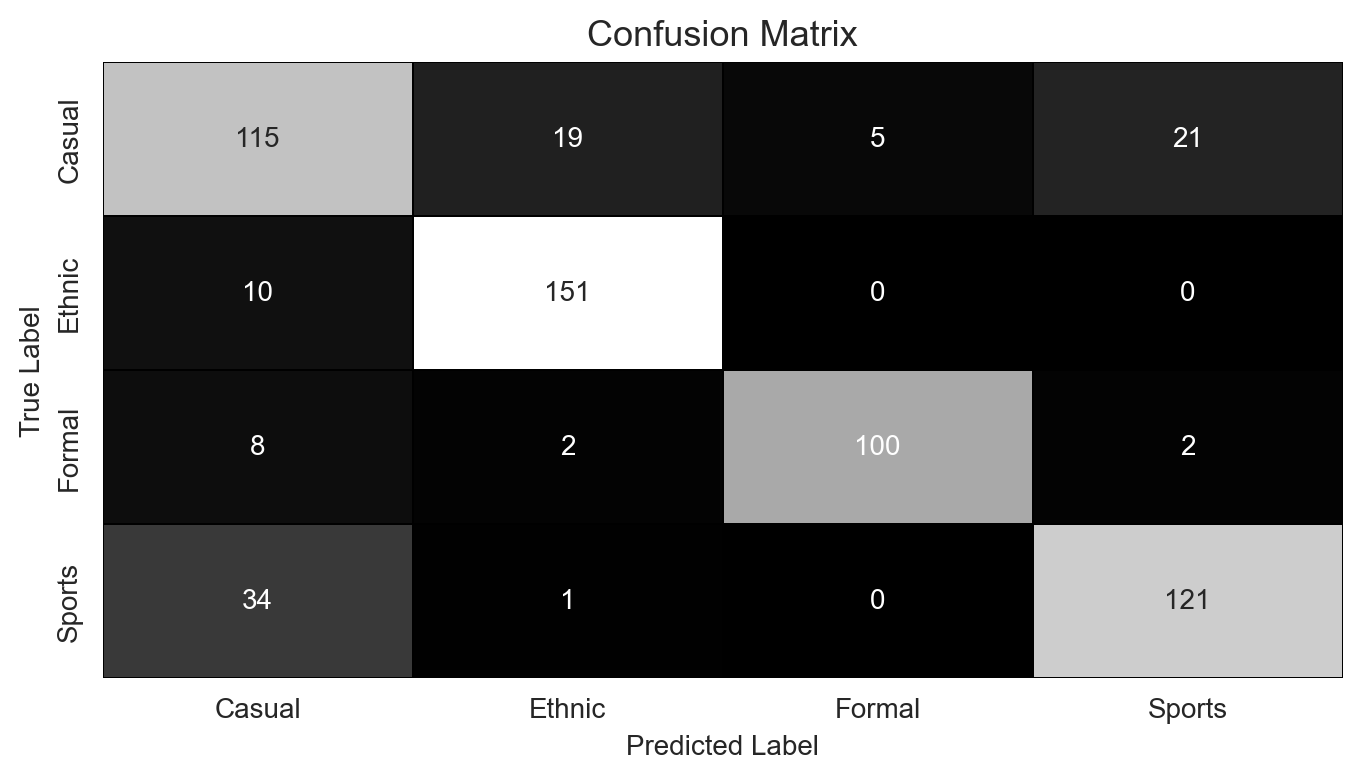

In [120]:
confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

<a id='20'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> submission </h2> </div>
Make predictions on kaggle test data for submission.

In [121]:
size =(128,128)

# loading into dataframe
filenames = os.listdir(validate_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

In [122]:
# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     "../fashion_styles_recognition/Datasets/fashion-dataset/validate_styles/",
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = bat_size,
                                     target_size=size,
                                     shuffle = False)

# Test Prediction
test1_predict = model.predict(test1_idg,verbose = 0)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

Found 20 validated image filenames belonging to 1 classes.


In [123]:
# mapping
label_mapping = {0: 'Casual', 1: 'Ethnic', 2: 'Formal', 3: 'Sports',}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

,filename,label
0,Casual.25972.jpg,Casual
1,Casual.26912.jpg,Casual
2,Casual.4393.jpg,Casual
3,Casual.52081.jpg,Casual
4,Casual.7026.jpg,Casual


In [124]:
# csv file output for submission
# sub = pd.read_csv('../fashion_styles_recognition/Datasets/sampleSubmission.csv',index_col='id')

sub = pd.DataFrame(columns = ['id','label'])

sub['id'] = test_data['filename']
sub['label'] = y_test_pred

sub.to_csv('../fashion_styles_recognition/Datasets/submission.csv',index=True)

<a id='21'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Visualize Classified Images  </h3> </div>

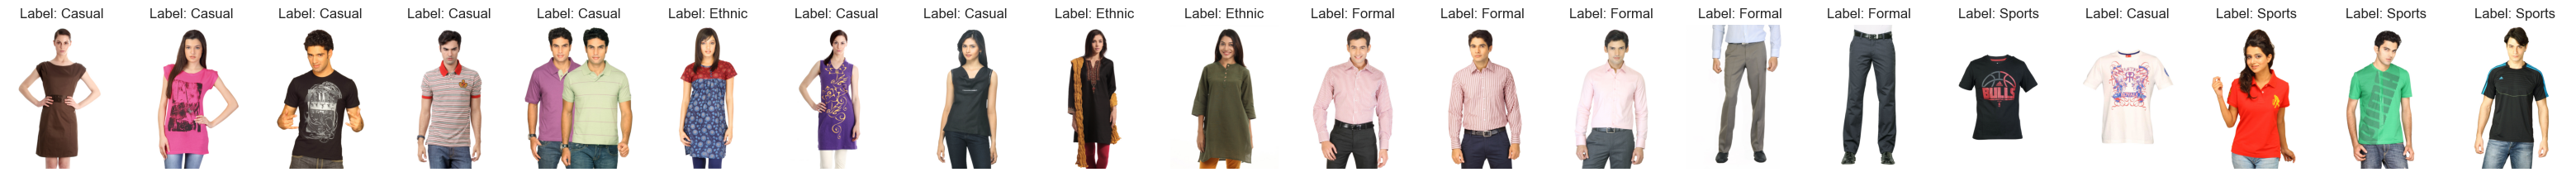

In [125]:
fig, axes = plt.subplots(1, 20, figsize=(40, 4))
for idx in range(20):
    image_path = os.path.join(validate_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()


<a id='22'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Conclusion </h2> </div>


We successfully built a deep neural network model by implementing Convolutional Neural Network (CNN) to classify dog and cat images with very high accuracy 82.7 %. 

The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.

The Fashion Stykes Classification model demonstrates the successful implementation of a Convolutional Neural Network for image classification tasks. By accurately distinguishing between images of different styles, this project showcases the potential of deep learning algorithms in solving real-world problems involving image analysis. Through this project, we aim to inspire further exploration of CNNs and their applications in various domains.